# Dimensionality Reduction

Dataset Description:
Instances in this dataset contain audio features extracted from 1059 wave files. The data is labelled based on the geographical origin of music (33 classes/countries/areas).
Note:​ Use the class labels only to verify the performance of the clustering.
116 columns are audio features of the track, and the last one columns are the origin of
the music.

Source:​ http://archive.ics.uci.edu/ml/datasets/geographical+original+of+music


Task

The task is to use PCA for dimensionality reduction and visualization. For your chosen k, do the following:

    a) Project your data into 2D plane using PCA and color code the clusters. Use scatter plot.
    
    b) Choose the following number of components for PCA: 2, 4, 8, 16, 32. Do the clustering on the reduced dataset and compute the Rand index.

## Importing required libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn import preprocessing
import copy

## Importing data

In [0]:
data = pd.read_csv("default_plus_chromatic_features_1059_tracks_new.csv", header = None)

In [0]:
data = data.rename(columns = {116 : 'Labels'})
data.insert(0,"ID",data.index)

## Frequency Encoding

In [0]:
def freq_encoder(data):
    #Transforming the data frame to include a frequency of label column
    data_copy = copy.deepcopy(data.assign(freq=data.groupby('Labels')['ID'].transform('count')).sort_values(by=['freq','ID'],ascending=[False,True]))
    data_copy.insert(0,"ind",data.index)
    #Inserting a sudo Indexing column
    
    e=list(data_copy['ind'])
    l=list(data_copy['Labels'])
    #sudo Indeces and labels 
    
    indexes = np.unique(l, return_index=True)[1]
    Freq_sorted_Unique = [l[index] for index in sorted(indexes)]
    #The frequency of label column sorted descendingly
    
    li = (np.arange(len(Freq_sorted_Unique)))
    #Encoding each frequency count to value between 0-32
    
    y = np.zeros(len(e))
    
    for i in range(0,len(l)): 
        for j in range(0,len(Freq_sorted_Unique)):
            if l[i] == Freq_sorted_Unique[j]:
                y[i] = li[j]
    #y contains the encoded labels           
                
    #Extracting features and labels to X,Y
    Y = copy.deepcopy(data_copy.iloc[:,len(data_copy.columns)-2])
    X1 = copy.deepcopy(data_copy.drop(data_copy.columns[len(data_copy.columns)-1], axis=1))
    X = copy.deepcopy(data_copy.iloc[:,2:len(data_copy.columns)-2]).reset_index(inplace = False).iloc[:,1:len(data_copy.columns)-1]
    return(data_copy,y,X,Y)

In [0]:
#Frequency encoded
data_freq,Y_freq_enc,X_freq,Y_freq = freq_encoder(data)

## Visualisation function

In [0]:
def visualize_cluster(X, label_ids, id_to_label_dict, text1, text2):
    
    #Figure with 2 subplots
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20,10))
    f.suptitle("PCA with 2 components", fontsize=16)
    
    #Scatter plot
    ax1.scatter(X[:, 0], X[:, 1], c='blue', s=40, cmap='jet', zorder=2,alpha=0.8)

    for i,label_id in enumerate(np.unique(label_ids)):
        idx = np.where(label_ids==label_id)[0]
        if label_id in id_to_label_dict:
            label = id_to_label_dict[label_id]
        else:
            label = id_to_label_dict.update([(label_id, label_id)])
        ax2.scatter(X[idx, 0], X[idx, 1],
                    color= plt.cm.Set1(i / float(len(set(list(y_pred_pca))))),
                    linewidth='1',
                    alpha=0.8,
                    label=id_to_label_dict[label_id])

    ax2.set_title(text1)
    ax1.set_title(text2)

    ax2.legend()
    #plt.savefig('PCA with 2 components')
    plt.show()
    

## PCA

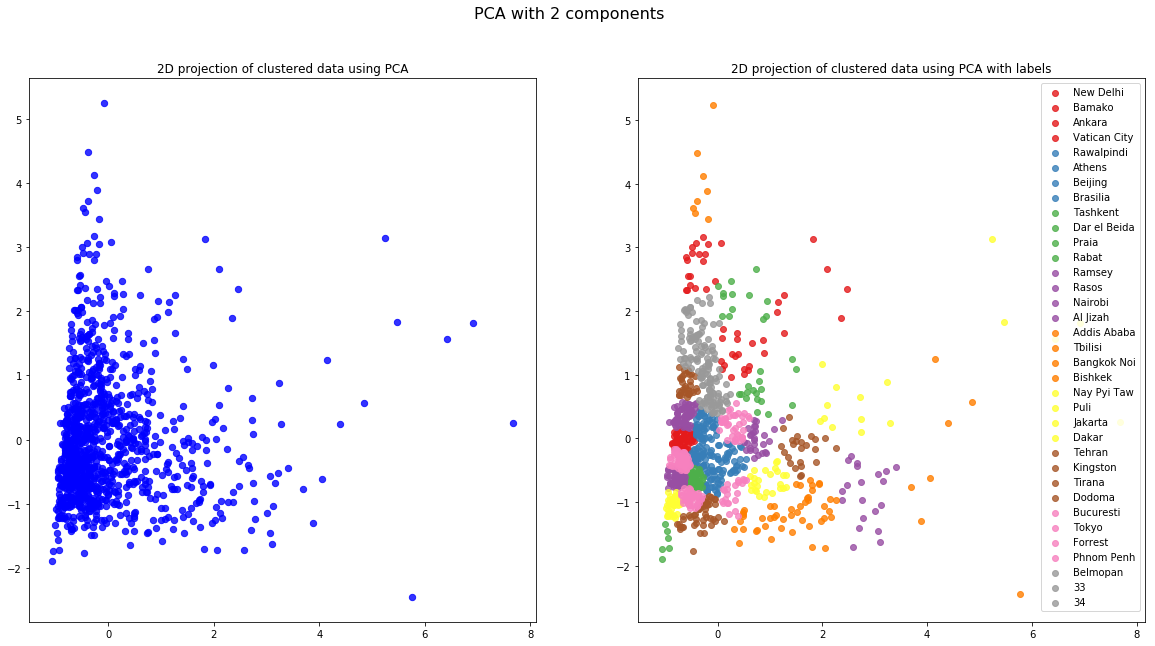

In [0]:
id_to_label_dict = {k:v for k, v in zip(Y_freq_enc,Y_freq)}


#K = 30, as K = 35 isnt accepted 
kmeans = KMeans(n_clusters=35, init="random",random_state=12, n_init=10, max_iter=200) 

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_freq)
pca_result = StandardScaler().fit_transform(pca_result)
y_pred_pca = kmeans.fit_predict(pca_result)

visualize_cluster(pca_result, y_pred_pca, id_to_label_dict,'2D projection of clustered data using PCA with labels','2D projection of clustered data using PCA' )


## Evaluation

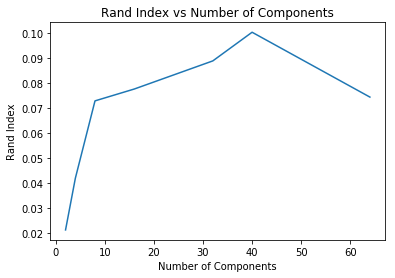

N components,2,4,8,16,32,40,64
RI,0.0213,0.042,0.0729,0.0777,0.0889,0.1004,0.0744


In [0]:
RI_PCA = []
n = [2,4,8,16,32,40,64]

kmeans = KMeans(n_clusters=35, init="random",random_state=12, n_init=10, max_iter=200) 

for i in n:
    pca = PCA(n_components=i)
    pca_result = pca.fit_transform(X_freq)
    pca_result = StandardScaler().fit_transform(pca_result)
    y_pred_pca = kmeans.fit_predict(pca_result)
    RI_PCA.append(adjusted_rand_score(Y_freq_enc,y_pred_pca))

#Visualising RI vs N
plt.plot(n,RI_PCA)
plt.ylabel('Rand Index')
plt.xlabel('Number of Components')
plt.title('Rand Index vs Number of Components')
plt.show()
#plt.savefig('Rand Index vs Number of Components')

#Tabularizing RI and N 
table_PCA = pd.DataFrame([np.round(RI_PCA,4)], columns = n, index =  ("RI",), dtype = object).rename_axis('N components', axis=1)
#table_PCA.to_csv("Rand Index vs Number of Components.csv")
display(table_PCA)

It can be observed that taking **N = 16** is best